# COMS-E6998-010: Homework 4
__Name:__ Nicholas Christman (n2677)   
__Due:__  Nov. 22, 2002


In [1]:
from __future__ import print_function, division

import sys
import time
import os
import copy
import numpy as np
import pandas
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# plt.ion()   # interactive mode

# set global seed
seed = 6998
torch.manual_seed(seed)

In [2]:
# use a GPU if there is one available
cuda_availability = torch.cuda.is_available()
if cuda_availability:
    device = torch.device('cuda:{}'.format(torch.cuda.current_device()))
else:
    device = 'cpu'
print('\n*************************')
print('GPU Available: {}'.format(cuda_availability))
print('Current Device: {}'.format(device))
print('*************************\n')
# display the GPU info
if cuda_availability:
    !nvidia-smi


*************************
GPU Available: True
Current Device: cuda:0
*************************

Mon Nov 16 00:30:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+----------------------------------------------------------------------

# Problem 1 - Transfer learning: Shallow learning vs Finetuning, Pytorch (30)

Two major transfer learning scenarios are as follows:   
* Finetuning the base model: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on Imagenet dataset. Rest of the training looks as usual however the learning rate schedule for transfer learning may be different.
* Base model as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.  

The following references were used to answer this problem:   
[1] Pytorch blog. Transfer Learning for Computer Vision Tutorial by S. Chilamkurthy   
&emsp; Available at https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html   
[2] Notes on Transfer Learning. CS231n Convolutional Neural Networks for Visual Recognition.   
&emsp; Available at https://cs231n.github.io/transfer-learning/   
[3] Visual Domain Decathlon (https://www.robots.ox.ac.uk/~vgg/decathlon/)   

In [4]:
# used one time to extract dataset
# # to extract tar
# import tarfile
# tar = tarfile.open("data/ucf101.tar", 'r')
# tar.extractall()
# tar.close()

In [181]:
###### Functions for Problem 1 ######

# function taken from the Pytorch tutorial [2]
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def train_model(model, criterion, optimizer, scheduler, 
                num_epochs=25, gpu_check=False, 
                start_epoch=0, save_epochs=0, 
                save_dir='', history={}, verbose=0):
    since = time.time()
    
    print('Training model...')
    print('=' * 20)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # if we aren't loading a model, start a new history dict
    if not history:
        history = {'train': {
                            'epoch': [],
                            'time': [],
                            'lr': [],
                            'loss': [],
                            'acc': [],
                            'best_acc': 0.0
                        }, 
                   'val': {
                           'epoch': [],
                           'time': [],
                           'lr': [],
                           'loss': [],
                           'acc': [],
                           'best_acc': 0.0
                       }
                  }

    for epoch in range(start_epoch, num_epochs):
        
        print('Epoch {}/{} (lr = {:.3e})'.format(epoch+1, num_epochs,
                                             optimizer.param_groups[0]['lr']))
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            phase_start = time.time()

            # use temp variable for brevity 
            epoch_hist = history[phase]

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            num_iters = len(dataloaders[phase])
            iter_time = 0
            for iters, (inputs, labels) in enumerate(dataloaders[phase]):
                iter_start = time.time()
                # move data to "device" (i.e., GPU)
                inputs, labels = inputs.to(device), labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                iter_time += (time.time() - iter_start)
                if (iters % 10 == 0 or iters == num_iters) or verbose == 1:
                    loss_data = loss.item() 
                    print('\r{} [{}/{} ({:.0f}%)]   Time: {:.4f}   Loss: {:.4f}'.
                            format(phase_str[phase], 
                                   iters * len(inputs), 
                                   len(dataloaders[phase].dataset),
                                   100. * iters / len(dataloaders[phase]), 
                                   iter_time, loss_data), end='')
            # store some stats
            epoch_time = time.time() - phase_start

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('\r{} [Done!]   Time: {:.4f}   Loss: {:.4f}   Acc: {:.4f}'.
                   format(phase_str[phase], epoch_time, 
                         epoch_loss, epoch_acc, end=''))

            # store the best accuracy and deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
#                 epoch_hist['best_acc'] = best_acc.data.cpu().numpy().item()
                best_model_wts = copy.deepcopy(model.state_dict())


            # store the history
            epoch_hist['epoch'].append(epoch) # added in case loading history
            epoch_hist['time'].append(epoch_time)
            epoch_hist['lr'].append(optimizer.param_groups[0]['lr'])
            epoch_hist['loss'].append(epoch_loss)
            epoch_hist['acc'].append(epoch_acc.data.cpu().numpy().item())
            epoch_hist['best_acc'] = np.max(epoch_hist['acc'])


        # for debug, check gpu performance
        if gpu_check:
            return model, history
        
        if (epoch > 0 and epoch != num_epochs-1) and \
            ((epoch+1) % save_epochs == 0 and save_dir):
            checkpoint=os.path.join(save_dir, 
                                    'E{}_checkpoint.th'.format(epoch+1))
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_acc': best_acc,
            }, filename=checkpoint)
            # dump the data for later
            json_file = os.path.join(save_dir,
                                     'E{}_history.json'.format(epoch+1))
            with open(json_file, 'w') as fp:
                json.dump(history, fp)
                
            print(' + Saved checkpoint \'{}\''.format(checkpoint))
        
        # console output        
        print('-' * 20)
    if save_dir:
        checkpoint= os.path.join(save_dir, 'final_model.th')
        # save the model
        save_checkpoint({
            'state_dict': model.state_dict(),
            'best_acc': best_acc,
        }, filename=checkpoint)
        # dump the data for later
        with open(os.path.join(save_dir,'final_history.json'), 'w') as fp:
            json.dump(history, fp)
        print(' + Saved checkpoint \'{}\''.format(checkpoint))
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        

def load_checkpoint(model,model_dir,start_epoch):
    # if model exists, then try to load it
    path = os.path.join(model_dir,'E{}_checkpoint.th'.format(start_epoch))
    if os.path.isfile(path):
         # resume from checkpoint if Colab booted us during training
        print("=> Loading checkpoint '{}'".format(path))
        checkpoint = torch.load(path)
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> Loaded checkpoint (epoch {})" .format(checkpoint['epoch']))
    else:
        print("=> No checkpoint found at '{}'".format(path))
        sys.exit()
    # load history structure
    history_file = os.path.join(model_dir,'E{}_history.json'.format(start_epoch))
    if os.path.isfile(history_file):
        with open(history_file) as json_file:
            history = json.load(json_file) 
    else:
        print('History file \'{}\' does not exist.'.format(checkpoint))
   
    return model,history


def save_checkpoint(state, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)
    
###### Global Vars for Problem 1 ######
phase_str = {'train': 'Training', 'val': 'Validating'}

In [189]:
# hyperparameters
batch_size = 64
num_epochs = 200
momentum = 0.9
lr_init = 0.001
lr_decay = 0.1
lr_epochs = [np.floor(0.3*num_epochs),
              np.floor(0.6*num_epochs),
              np.floor(0.9*num_epochs)]


train_phases = ['train', 'val']

# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # ImageNet is 224x224x3, so we need to stay the same
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224), # ImageNet is 224x224x3, so we need to stay the same
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'data/dtd'
data_name = 'ucf101'
data_dir = os.path.join('data',data_name)

# the training & validation data
image_datasets = {}
dataloaders = {}
dataset_sizes = {}
for x in train_phases:
    image_datasets[x] = datasets.ImageFolder(os.path.join(data_dir, x), 
                                             data_transforms[x])

    dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], 
                                                 batch_size=batch_size,
                                                 shuffle=True, 
                                                 num_workers=4)
    
    dataset_sizes[x] = len(image_datasets[x])

# get some data info
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print('Number of classes: {}'.format(num_classes))
for x in ['train', 'val']:
    print('Dataset \'{}\' size: {}'.format(x,dataset_sizes[x]))


# read in the annotations and get the actual class names
# ann_dir = 'data/dtd_ann'
ann_dir = os.path.join('data',data_name+'_ann')

# with open(os.path.join(ann_dir,'dtd_train.json')) as f:
with open(os.path.join(ann_dir,'ucf101_train.json')) as f:
    train_ann = json.load(f)
# extract the "class_names" (last 4 digits of category id) and actual names (class labels)
real_names = dict([ (str(cat['id'])[-4:], cat['name']) for cat in train_ann['categories'] ])
    
# Count the number of images per class
from collections import Counter
tmp = dict(Counter(image_datasets['train'].targets))
# for displaying, let's replace the class # with the actual class name
for k, v in real_names.items():
    tmp[v] = tmp[int(k)-1]
    del tmp[int(k)-1]
print('Number of images per class:')
min_vals = min(tmp.values())
# min_classes = [key for key in tmp if tmp[key] == min_vals] 
print('  > Minimum count of {}'.format(min_vals))
max_vals = max(tmp.values())
# max_classes = [key for key in tmp if tmp[key] == max_vals] 
print('  > Maximum count of {}'.format(max_vals))
avg_vals = np.mean(list(tmp.values()))
print('  > Mean count of {:0.3f}'.format(avg_vals))


Number of classes: 101
Dataset 'train' size: 7585
Dataset 'val' size: 1952
Number of images per class:
  > Minimum count of 57
  > Maximum count of 96
  > Mean count of 75.099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


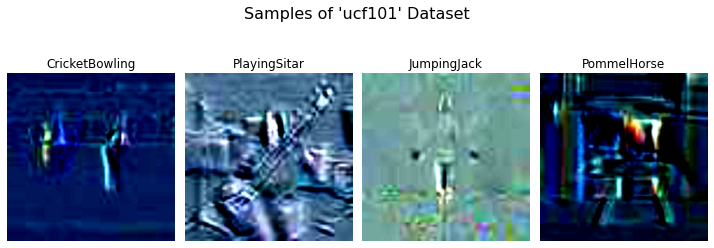

In [191]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))
# select 4 unique classes to demo
uni, ind = np.unique(classes, return_index=True)
use = np.random.choice(ind, 4, replace=False)
# display samles
title = 'Samples of \'{}\' Dataset'.format(data_name)
fig = plt.figure(figsize=(10,4))
fig.suptitle(title, fontsize=16)
for i,u in enumerate(use):
    axn = fig.add_subplot(1, 4, i+1)
    axn.set_title(real_names[class_names[classes[u]]])
    axn.axis('off')
    axn.imshow(inputs[u].permute(1, 2, 0))     
plt.tight_layout(pad=1.0)
plt.show()

### 1(a) 
__Dataset Explanation:__  

For this problem I chose to use the [UCF101 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF101.php "ucf101 dataset"). According the the referenced website, the UCF101 dataset consists of "realistic action videos, collected from YouTube, having 101 action categories." As the descrption states, the UCF101 dataset has 101 classes representing different actions (e.g., longjump, headmassage, fencing, etc.). The data is split into training, validation, and test sets consiting of 7629, 1908, and 3783 images, respectively. As displayed above, the number of images per class varies: there is a minimum of 57 images per class, a maximum of 96 images per class, and a mean of 75.099 images per class. Also displayed above are 4 sample images from the dataset.   

*Note: The Visual Domain Decathlon dataset abstracted away the actual class names, so 4 extra lines of code (above) were implemened to grab the actual class names out of the annotations file.*

### 1(b)
Below we will load a pretrained Resnet50 model (using Pytorch)

In [193]:
prob_name = 'prob1b'
save_epochs = 10
history = {}

# prepare the pre-trained model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# change the output layer to match number of new classes
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# for checkpoints (save/load dir)
start_epoch = 0
save_dir = os.path.join('checkpoints',prob_name)
if not os.path.isdir(save_dir): os.mkdir(save_dir) # create save_dir
# model_ft, history = load_checkpoint(model_ft, save_dir, start_epoch) # uncomment to load model

# move model to the GPU
model_ft = model_ft.to(device)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=momentum)

# Decay learning rate per hyperparameters above
lr_scheduler_ft = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft,
                                                      milestones=lr_epochs, 
                                                      gamma=lr_decay)#,
lr_scheduler_ft.last_epoch = start_epoch - 1

model_ft, history = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft,
                                num_epochs=num_epochs, start_epoch=start_epoch, 
                                save_epochs=save_epochs, save_dir=save_dir, 
                                history=history, verbose=1)

Training model...
Epoch 1/200 (lr = 1.000e-03)
Training [576/7585 (8%)]   Time: 6.2293   Loss: 4.5662

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/

KeyboardInterrupt: 

In [192]:
# # history={}
# prob_name = 'prob1b'
# # if we need to plot past data, clear 'history'
# if not history:
#     # load the stored json data into dictionary if it doesn't exist
#     hist_file = 'checkpoints/{}/final_history.json'.format(prob_name)
#     print(hist_file)
#     if os.path.isfile(hist_file):
#         with open(hist_file) as json_file:
#             history = json.load(json_file)
#             print('Loaded data from JSON file. (file:{})\n'.format(hist_file))
#     else:
#         sys.exit('File \'{}\' does not exist.'.format(hist_file))

# # display the resuls
# plt_train = history['train']
# plt_val = history['val']
# # best acc text
# best_train = 'Best acc: {:0.3f}'.format(plt_train['best_acc'])
# best_val = 'Best acc: {:0.3f}'.format(plt_val['best_acc'] )
# # define figure
# title = 'Q1.1b - Finetuning Resnet50 for \'{}\' Dataset'.format(data_name)
# fig = plt.figure(figsize=(10,8))
# fig.suptitle(title, fontsize=16)
# ax1 = fig.add_subplot(2, 2, 1)
# # loss plots
# ax1.set_title('Training')
# ax1.set_ylabel('Loss')
# ax1.plot(plt_train['epoch'], plt_train['loss'], color='indigo')
# ##
# ax2 = fig.add_subplot(2, 2, 2,sharex = ax1)
# ax2.set_title('Validation')
# ax2.plot(plt_val['epoch'], plt_val['loss'], color='teal')
# ##
# # accuracy plots
# ax3 = fig.add_subplot(2, 2, 3,sharex = ax1)
# ax3.set_ylabel('Accuracy')
# ax3.set_xlabel('Epoch')
# ax3.plot(plt_train['epoch'], plt_train['acc'], color='indigo')
# ax3.text(0.05, 0.95, best_train, transform=ax3.transAxes, fontsize=10,
#         verticalalignment='top')
# ##
# ax4 = fig.add_subplot(2, 2, 4,sharex = ax1)
# ax4.set_xlabel('Epoch')
# ax4.plot(plt_val['epoch'], plt_val['acc'], color='teal')
# ax4.text(0.05, 0.95, best_val, transform=ax4.transAxes, fontsize=10,
#         verticalalignment='top')
# ##
# # configure ticks/labels/layout
# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.setp(ax2.get_xticklabels(), visible=False)
# plt.subplots_adjust(wspace=.4, hspace=.1)
# # plt.tight_layout(pad=2.0)
# plt.show()

### 1(c)
_Per Piazza @283, we will have different initial LRs but will still decay at the same rate._

In [186]:
prob_name = 'prob1c_1'
save_epochs = 10
history = {}

##### PART 1: LR = 0.01
# for this part, we set initial training rate to 0.01
# but will use the same decay schedule
lr_init = 0.01

# prepare the pre-trained model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# change the output layer to match number of new classes
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# for checkpoints (save/load dir)
start_epoch = 0
save_dir = os.path.join('checkpoints',prob_name)
if not os.path.isdir(save_dir): os.mkdir(save_dir) # create save_dir
# model_ft, history = load_checkpoint(model_ft, save_dir, start_epoch) # uncomment to load model

# move model to the GPU
model_ft = model_ft.to(device)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=momentum)

# Decay learning rate per hyperparameters above
lr_scheduler_ft = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft,
                                                      milestones=lr_epochs, 
                                                      gamma=lr_decay)#,
lr_scheduler_ft.last_epoch = start_epoch - 1

model_ft, history = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft,
                                num_epochs=num_epochs, start_epoch=start_epoch, 
                                save_epochs=save_epochs, save_dir=save_dir, 
                                history=history, verbose=1)

Training model...
Epoch 1/10 (lr = 1.000e-02)
Training [Done!]   Time: 12.3005   Loss: 3.3686   Acc: 0.2099
Validating [Done!]   Time: 1.1807   Loss: 2.6808   Acc: 0.3509
--------------------
Epoch 2/10 (lr = 1.000e-02)
Training [Done!]   Time: 12.3682   Loss: 1.7177   Acc: 0.5349
Validating [Done!]   Time: 1.1912   Loss: 2.2730   Acc: 0.4314
--------------------
Epoch 3/10 (lr = 1.000e-02)
Training [Done!]   Time: 12.3370   Loss: 0.8487   Acc: 0.7611
Validating [Done!]   Time: 1.1811   Loss: 1.7993   Acc: 0.5441
--------------------
Epoch 4/10 (lr = 1.000e-02)
Training [Done!]   Time: 12.3307   Loss: 0.3905   Acc: 0.8871
Validating [Done!]   Time: 1.1879   Loss: 1.5766   Acc: 0.6189
--------------------
Epoch 5/10 (lr = 1.000e-03)
Training [Done!]   Time: 12.3646   Loss: 0.1159   Acc: 0.9723
Validating [Done!]   Time: 1.1812   Loss: 1.1254   Acc: 0.7059
--------------------
Epoch 6/10 (lr = 1.000e-03)
Training [Done!]   Time: 12.3946   Loss: 0.0362   Acc: 0.9966
Validating [Done!]   T

In [187]:
prob_name = 'prob1c_2'
save_epochs = 10
history = {}

##### PART 2: LR = 0.1
# for this part, we set initial training rate to 0.1
# but will use the same decay schedule
lr_init = 0.1

# prepare the pre-trained model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# change the output layer to match number of new classes
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# for checkpoints (save/load dir)
start_epoch = 0
save_dir = os.path.join('checkpoints',prob_name)
if not os.path.isdir(save_dir): os.mkdir(save_dir) # create save_dir
# model_ft, history = load_checkpoint(model_ft, save_dir, start_epoch) # uncomment to load model

# move model to the GPU
model_ft = model_ft.to(device)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr_init, momentum=momentum)

# Decay learning rate per hyperparameters above
lr_scheduler_ft = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft,
                                                      milestones=lr_epochs, 
                                                      gamma=lr_decay)#,
lr_scheduler_ft.last_epoch = start_epoch - 1

model_ft, history = train_model(model_ft, criterion, optimizer_ft, lr_scheduler_ft,
                                num_epochs=num_epochs, start_epoch=start_epoch, 
                                save_epochs=save_epochs, save_dir=save_dir, 
                                history=history, verbose=1)

Training model...
Epoch 1/10 (lr = 1.000e-01)
Training [Done!]   Time: 12.2734   Loss: 4.6005   Acc: 0.0240
Validating [Done!]   Time: 1.1628   Loss: 4.2771   Acc: 0.0256
--------------------
Epoch 2/10 (lr = 1.000e-01)
Training [Done!]   Time: 12.2438   Loss: 4.2809   Acc: 0.0293
Validating [Done!]   Time: 1.1889   Loss: 4.5085   Acc: 0.0302
--------------------
Epoch 3/10 (lr = 1.000e-01)
Training [Done!]   Time: 12.2611   Loss: 4.0565   Acc: 0.0563
Validating [Done!]   Time: 1.1834   Loss: 3.9260   Acc: 0.0789
--------------------
Epoch 4/10 (lr = 1.000e-01)
Training [Done!]   Time: 12.2904   Loss: 3.8368   Acc: 0.0882
Validating [Done!]   Time: 1.1769   Loss: 4.1479   Acc: 0.0763
--------------------
Epoch 5/10 (lr = 1.000e-02)
Training [Done!]   Time: 12.2400   Loss: 3.5094   Acc: 0.1463
Validating [Done!]   Time: 1.1707   Loss: 3.4392   Acc: 0.1588
--------------------
Epoch 6/10 (lr = 1.000e-02)
Training [Done!]   Time: 12.2381   Loss: 3.3207   Acc: 0.1752
Validating [Done!]   T

checkpoints/prob1b/final_history.json
Loaded data from JSON file. (file:checkpoints/prob1b/final_history.json)

checkpoints/prob1c_1/final_history.json
Loaded data from JSON file. (file:checkpoints/prob1c_1/final_history.json)

checkpoints/prob1c_2/final_history.json
Loaded data from JSON file. (file:checkpoints/prob1c_2/final_history.json)



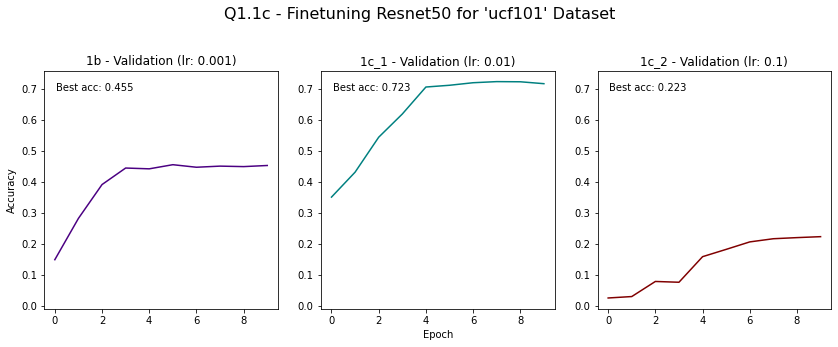

In [188]:
prob_names = ['prob1b','prob1c_1','prob1c_2']
history = {'prob1b':{},'prob1c_1':{},'prob1c_2':{}}
for prob_name in history.keys():
    # load the stored json data into dictionary if it doesn't exist
    hist_file = 'checkpoints/{}/final_history.json'.format(prob_name)
    print(hist_file)
    if os.path.isfile(hist_file):
        with open(hist_file) as json_file:
            history[prob_name] = json.load(json_file)
            print('Loaded data from JSON file. (file:{})\n'.format(hist_file))
    else:
        sys.exit('File \'{}\' does not exist.'.format(hist_file))

# display the resuls
plt_1b = history['prob1b']['val']
plt_1c1 = history['prob1c_1']['val']
plt_1c2 = history['prob1c_2']['val']

# best acc text
best_1b = 'Best acc: {:0.3f}'.format(plt_1b['best_acc'])
best_1c1 = 'Best acc: {:0.3f}'.format(plt_1c1['best_acc'] )
best_1c2 = 'Best acc: {:0.3f}'.format(plt_1c2['best_acc'] )

# define figure
title = 'Q1.1c - Finetuning Resnet50 for \'{}\' Dataset'.format(data_name)
fig = plt.figure(figsize=(12,5))
fig.suptitle(title, fontsize=16)
##
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('1b - Validation (lr: 0.001)')
ax1.set_ylabel('Accuracy')
ax1.plot(plt_1b['epoch'], plt_1b['acc'], color='indigo')
ax1.text(0.05, 0.95, best_1b, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top')
##
ax2 = fig.add_subplot(1, 3, 2,sharey = ax1)
ax2.set_title('1c_1 - Validation (lr: 0.01)')
ax2.set_xlabel('Epoch')
ax2.plot(plt_1c1['epoch'], plt_1c1['acc'], color='teal')
ax2.text(0.05, 0.95, best_1c1, transform=ax2.transAxes, fontsize=10,
        verticalalignment='top')
##
ax3 = fig.add_subplot(1, 3, 3,sharey = ax1)
ax3.set_title('1c_2 - Validation (lr: 0.1)')
ax3.plot(plt_1c2['epoch'], plt_1c2['acc'], color='maroon')
ax3.text(0.05, 0.95, best_1c2, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top')

##
# configure ticks/labels/layout
plt.tight_layout(pad=2.0)
plt.show()